# CTD Data, Density & Buoyancy Frequency Calculator

Import formatted CTD data from La Perouse/Line P cruises, calculate in situ density, and find buoyancy frequency through depth.

Barkley Canyon centred at approximately Lat 48.33 Long -126.03, so Rosette (deep) CTD casts from Station P4 are closest (approximately Lat 48.39 Long -126.39); a distance of about 27 km.

Winter casts are within January/February, and summer casts are within August/September.

## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import numpy as np
import scipy.signal as sig
import scipy.interpolate as interp
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib notebook

## CTD Data


Line P CTD data obtained from http://www.waterproperties.ca/linep/cruises.php. 

Format the .ctd file as .csv with pressure, temperature, and salinity as the first three columns, with headers.

In [221]:
CTD = np.genfromtxt('/Users/Kurtis/Documents/Python/Data/DFOLineP_P4/CTD/2009_winter.csv',skip_header=1,delimiter=',')
year = '2009'       # strings for output filenames and titles

In [222]:
P = -CTD[:,0]   # depth(pressure) [m]([dbar])
T = CTD[:,1]    # temperature [Celsius]
S = CTD[:,2]    # salinity, PSS-78 [PSU]
g = 9.81        # gravity, [m/(s**2)]

<IPython.core.display.Javascript object>


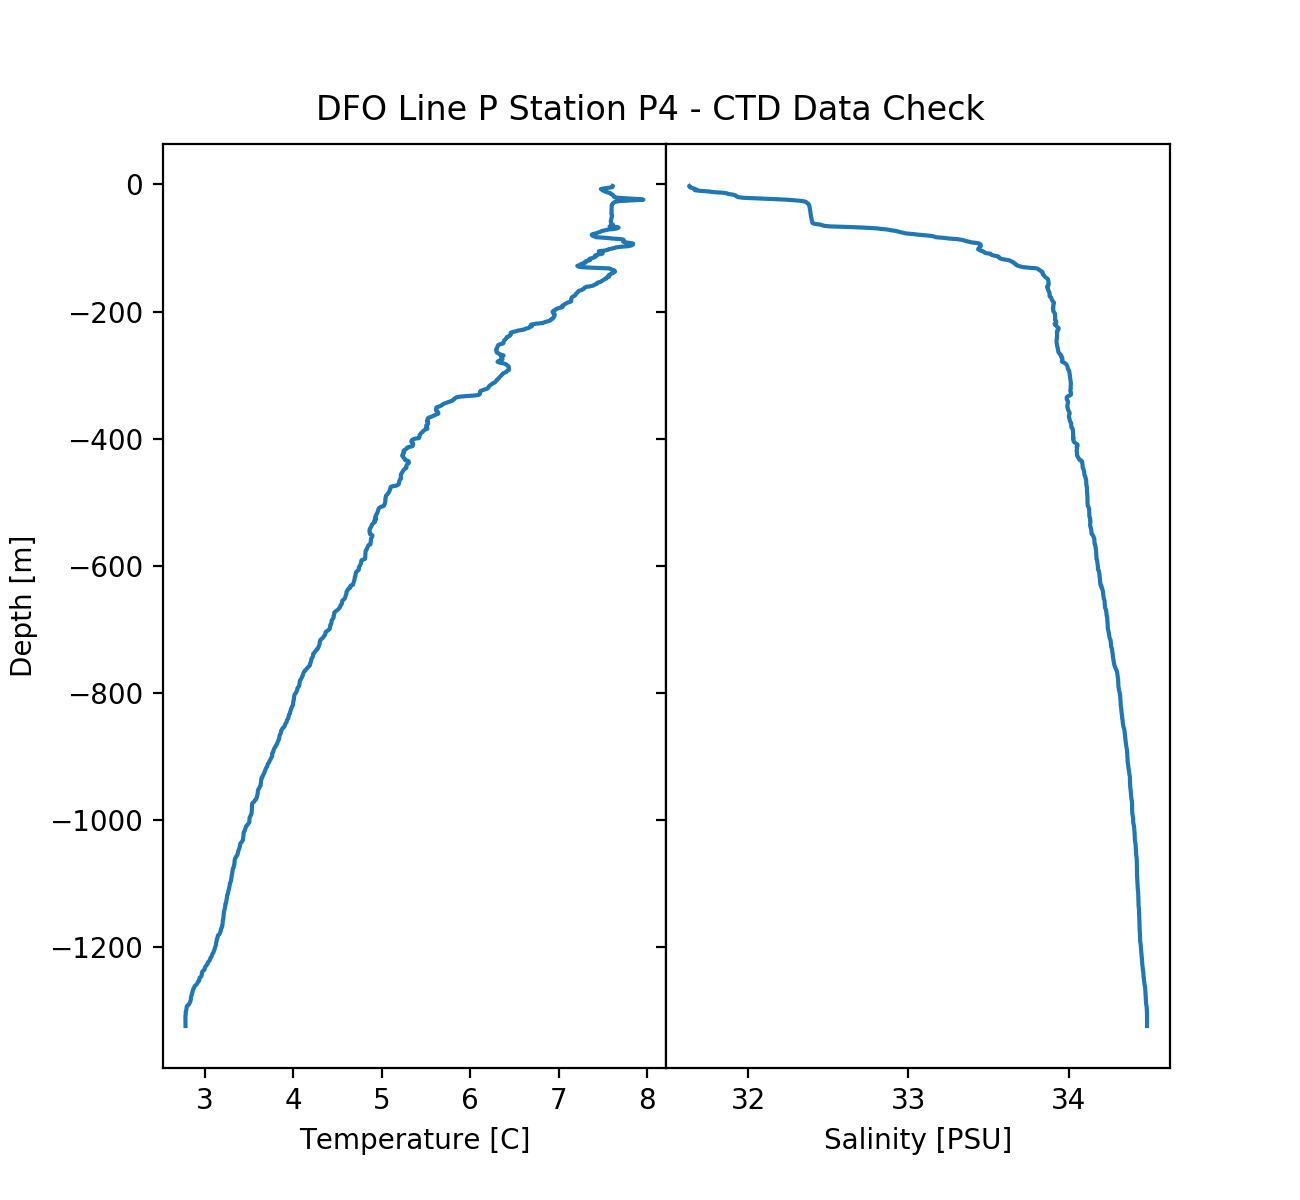

In [223]:
# plots to visually check data quality
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6.5,6),sharey=True)
ax1.plot(T,P)
ax1.set_xlabel('Temperature [C]')
ax1.set_ylabel('Depth [m]')
ax2.plot(S,P)
ax2.set_xlabel('Salinity [PSU]')
fig.subplots_adjust(wspace = 0.0)
fig.text(0.5, 0.9, 'DFO Line P Station P4 - CTD Data Check', ha='center', fontsize=12)
plt.show()

## Density Function

Based on readily available online EoS information from UNESCO (1983) and https://www.jfe-advantech.co.jp/eng/ocean/sensor/img/density.pdf.

In [224]:
# coefficients
a0 = 999.842594
a1 = 6.793952e-2
a2 = -9.095290e-3
a3 = 1.001685e-4
a4 = -1.120083e-6 
a5 = 6.536332e-9
b0 = 8.24493e-1
b1 = -4.0899e-3
b2 = 7.6438e-5
b3 = -8.2467e-7
b4 = 5.3875e-9
c0 = -5.72466e-3
c1 = 1.0227e-4
c2 = -1.6546e-6
d0 = 4.8314e-4
e0 = 19652.21 
e1 = 148.4206 
e2 = -2.327105 
e3 = 1.360477e-2
e4 = -5.155288e-5
f0 = 54.6746 
f1 = -0.603459 
f2 = 1.09987e-2 
f3 = -6.1670e-5
g0 = 7.944e-2
g1 = 1.6483e-2
g2 = -5.3009e-4
h0 = 3.239908 
h1 = 1.43713e-3 
h2 = 1.16092e-4 
h3 = -5.77905e-7
i0 = 2.2838e-3
i1 = -1.0981e-5
i2 = -1.6078e-6
j0 = 1.91075e-4
k0 = 8.50935e-5 
k1 = -6.12293e-6 
k2 = 5.2787e-8
m0 = -9.9348e-7 
m1 = 2.0816e-8 
m2 = 9.1697e-10

###############
def density(S,T,P):
    s = S
    t = T*1.00024
    p = P/10
    Kw = e0 + (e1*t) + (e2*(t**2)) + (e3*(t**3)) + (e4*(t**4))
    Aw = h0 + (h1*t) + (h2*(t**2)) + (h3*(t**3))
    Bw = k0 + (k1*t) + (k2*(t**2))
    A = Aw + ((i0 + (i1*t) + (i2*(t**2)))*s) + (j0*(s**(3/2)))
    B = Bw + ((m0 + (m1*t) + (m2*(t**2)))*s)
    KSt0 = Kw + ((f0 + (f1*t) + (f2*(t**2)) + (f3*(t**3)))*s) + ((g0 + (g1*t) + (g2*(t**2)))*(s**(3/2)))
    KStp = KSt0 + (A*p) + (B*(p**2))
    rhow = a0 + (a1*t) + (a2*(t**2)) + (a3*(t**3)) + (a4*(t**4)) + (a5*(t**5))
    rhoSt0 = rhow + ((b0 + (b1*t) + (b2*(t**2)) + (b3*(t**3)) + (b4*(t**4)))*s) + ((c0 + (c1*t) + \
                                                            (c2*(t**2)))*(s**(3/2))) + (d0*(s**2))
    rho = rhoSt0 / (1 - (p/KStp))
    return rho

## Buoyancy Frequency 

Calculated as $N^2 = -\frac{g}{\rho}\frac{\partial\rho}{\partial z}{}$.

### $N^2$ through depth

In [225]:
d = np.arange(len(P))                # range for depth indices
dz = 20                              # finite difference length, [m]
dz2 = dz/2                           # 1/2 dz for finite difference about a specific depth
dup = int(np.min(d) + dz2)           # upper depth index, with room for finite difference
dlow = int(np.max(d) - dz2)          # lower depth index, with room for finite difference
drange = dlow - dup                  # depth indice range for N**2 values
N2depth = np.zeros(drange)           # empty array for N**2 values
rhodepth = np.zeros(drange)          # empty array for density values

for i in range(dup,dlow,1):                          # loop for density and N**2 at each depth
    iup = int(i - dz2)                               # upper finite difference index
    ilow = int(i + dz2)                              # lower finite difference index
    rho_up = density(S[iup],T[iup],P[iup])           # upper density value
    rho = density(S[i],T[i],P[i])                    # in situ density value
    rho_low = density(S[ilow],T[ilow],P[ilow])       # lower density value
    dpdz = (rho_up-rho_low)/((P[iup])-(P[ilow]))     # density gradient, finite difference about depth
    N2 = abs( (-g/rho) * (dpdz) )                    # in situ N**2 value
    N2depth[iup] = N2                                # add in situ N**2 value to depth array
    rhodepth[iup] = rho

<IPython.core.display.Javascript object>


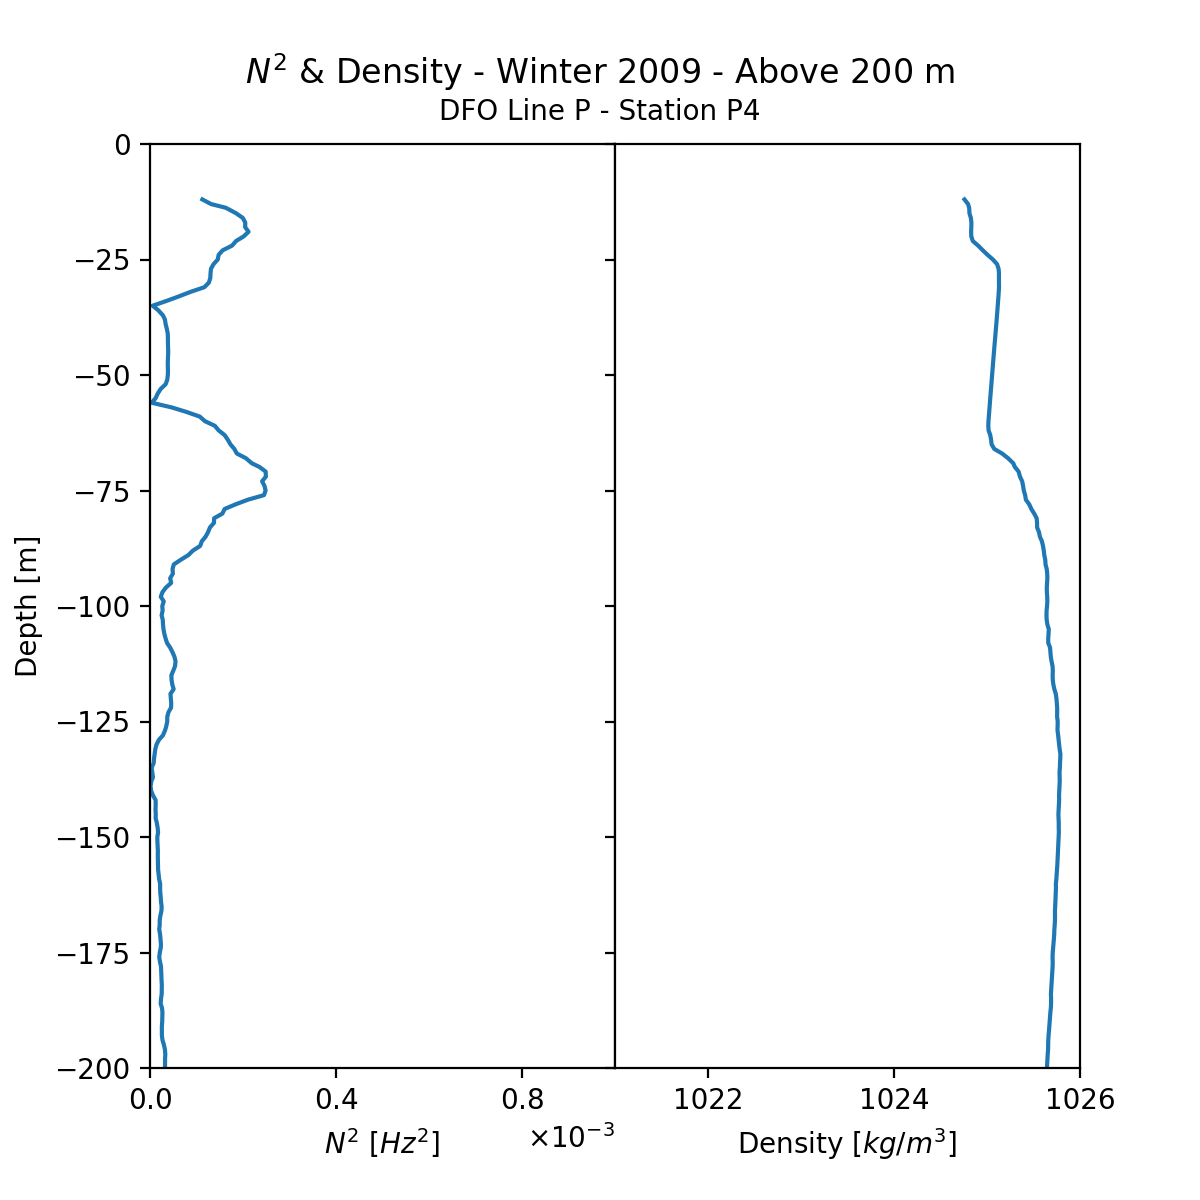

In [226]:
# plot N**2 and density through upper depth
N2P = P[dup:dlow]       # depth scale for y-axis

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(6,6),sharey=True)
fig.subplots_adjust(wspace=0.0)
ax0.plot(N2depth,N2P)
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('$N^2$ [$Hz^2$]')
ax0.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax0.set_xlim(0,1e-3)
ax0.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.plot(rhodepth,N2P)
ax1.set_xlabel('Density [$kg/m^3$]')
ax1.set_ylim(-200,0)
ax1.set_xlim(1021,1026)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.text(0.5, 0.93, f'$N^2$ & Density - Winter {year} - Above 200 m', ha='center', fontsize=12)
fig.text(0.5, 0.9, 'DFO Line P - Station P4', ha='center', fontsize=10)
plt.show()

plt.savefig(fname=f'./N2_plots/N2_upper_winter_'+year+'.pdf',format='pdf')

<IPython.core.display.Javascript object>


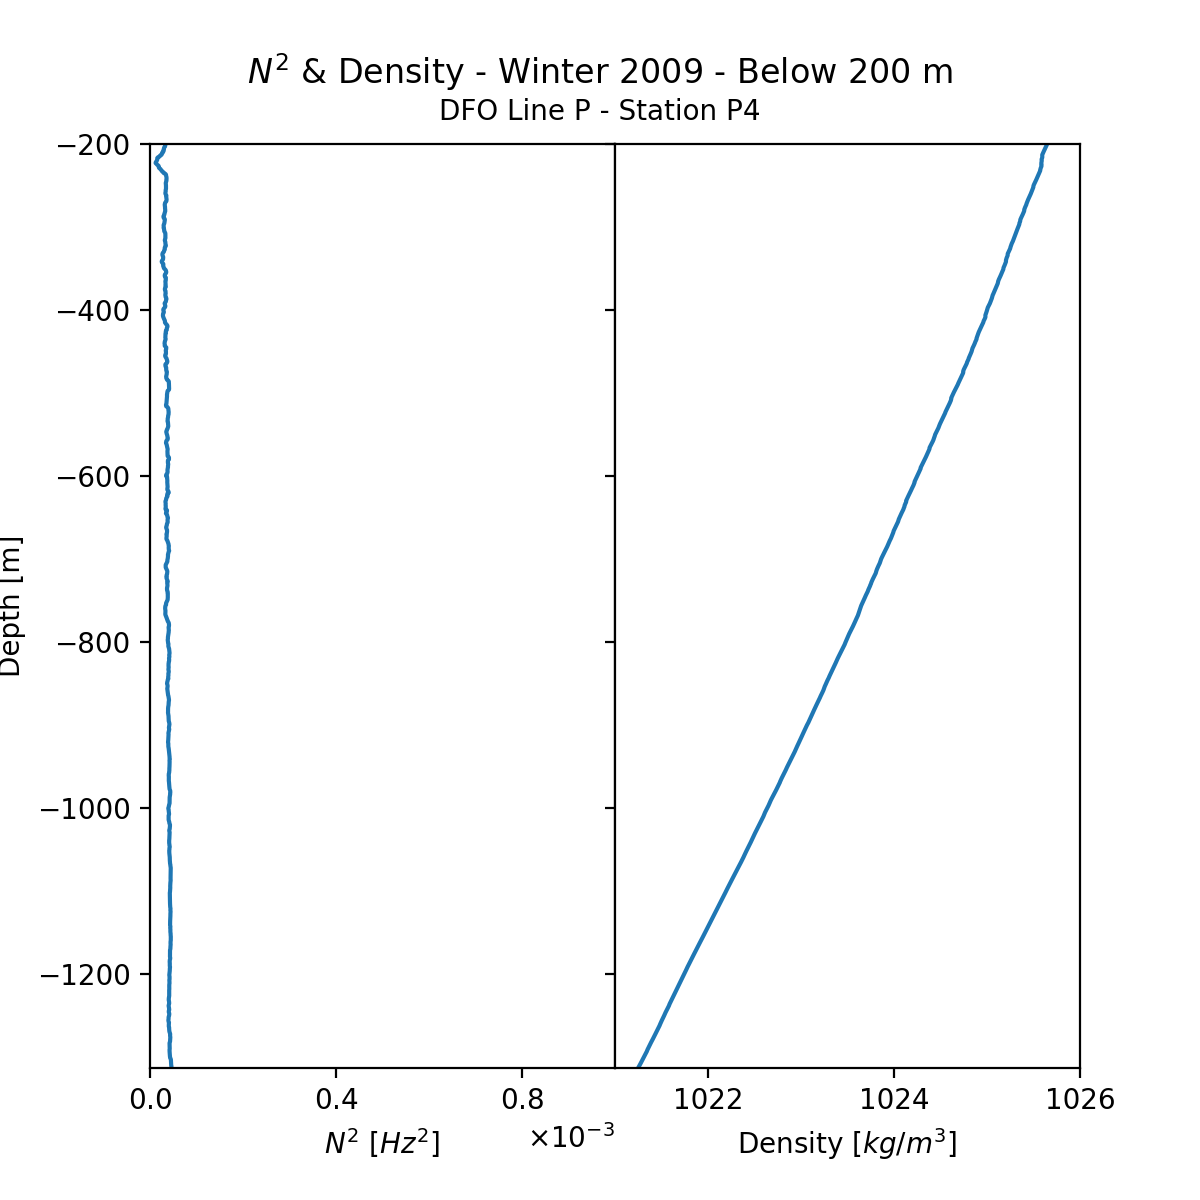

In [227]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(6,6),sharey=True)
fig.subplots_adjust(wspace=0.0)
ax0.plot(N2depth,N2P)
ax0.set_ylabel('Depth [m]')
ax0.set_xlabel('$N^2$ [$Hz^2$]')
ax0.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)
ax0.set_xlim(0,1e-3)
ax0.xaxis.set_major_locator(plt.MaxNLocator(3))
ax1.plot(rhodepth,N2P)
ax1.set_xlabel('Density [$kg/m^3$]')
ax1.set_ylim(np.min(N2P),-200)
ax1.set_xlim(1021,1026)
ax1.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.text(0.5, 0.93, f'$N^2$ & Density - Winter {year} - Below 200 m', ha='center', fontsize=12)
fig.text(0.5, 0.9, 'DFO Line P - Station P4', ha='center', fontsize=10)
plt.show()

plt.savefig(fname='./N2_plots/N2_lower_winter_'+year+'.pdf',format='pdf')